## 1. Importing libraries

In [324]:
import torch
import gym
import numpy as np
import time
import cv2
import math
import random
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import warnings
import os
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, Flatten, Linear, MSELoss
from torch.optim import Adam, SGD
from torchinfo import summary

In [9]:
warnings.filterwarnings("ignore")

## 2. Checking availability of GPU

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") 
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn)
    print('Device name:', torch.cuda.get_device_name(0))

Device:  cuda
__CUDNN VERSION: <module 'torch.backends.cudnn' from '/home/mario.cantero/.conda/envs/AIProject/lib/python3.8/site-packages/torch/backends/cudnn/__init__.py'>
Device name: Quadro RTX 6000


## 3. Creating the environment

In [162]:
env_si_or = gym.make("ALE/SpaceInvaders-v5")
env_si_or.seed(0);

env_c_or = gym.make("ALE/Carnival-v5")
env_c_or.seed(0);

env_ar_or = gym.make("ALE/AirRaid-v5")
env_ar_or.seed(0);

In [163]:
env_si = gym.make("SpaceInvaders-v0")
env_si.seed(0);

env_c = gym.make("Carnival-v0")
env_c.seed(0);

env_ar = gym.make("AirRaid-v0")
env_ar.seed(0);

## 4. Performance of a random policy

In [169]:
def random_play(env):
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
        time.sleep(0.1)
    env.close()

In [291]:
random_play(env_si)

Your Score at end of game is:  85.0


In [165]:
random_play(env_c)

Your Score at end of game is:  740.0


In [170]:
random_play(env_ar)

Your Score at end of game is:  475.0


In [167]:
random_play(env_ar_or)

Your Score at end of game is:  500.0


## 5. Exploring the environments

In [304]:
for env in [env_si_or, env_c_or, env_ar_or]:
    print(f"The size of a {str(env.spec)} frame is: ", env.observation_space.shape)
    print("No. of Actions: ", env.action_space.n)

The size of a EnvSpec(ALE/SpaceInvaders-v5) frame is:  (210, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/Carnival-v5) frame is:  (214, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/AirRaid-v5) frame is:  (250, 160, 3)
No. of Actions:  6


In [305]:
for env in [env_si, env_c, env_ar]:
    print(f"The size of a {str(env.spec)} frame is: ", env.observation_space.shape)
    print("No. of Actions: ", env.action_space.n)

The size of a EnvSpec(SpaceInvaders-v0) frame is:  (210, 160, 3)
No. of Actions:  6
The size of a EnvSpec(Carnival-v0) frame is:  (214, 160, 3)
No. of Actions:  6
The size of a EnvSpec(AirRaid-v0) frame is:  (250, 160, 3)
No. of Actions:  6


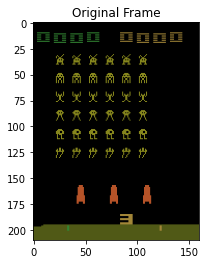

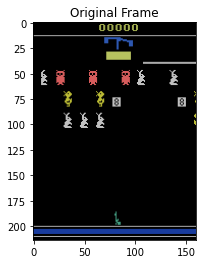

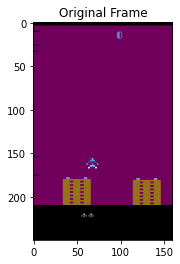

In [19]:
for env in [env_si, env_c, env_ar]:
    env.reset()
    plt.figure()
    plt.imshow(env.reset())
    plt.title('Original Frame')
    plt.show()

## 6. Image preprocessing and stacking frames

#### 6.1 Functions

In [177]:
def preprocess_state(state, game):
    # []
    game_name = str(game.spec)
    if game_name == "EnvSpec(SpaceInvaders-v0)":
        #initially, the image has a shape of (210, 160, 3)
        #crop and resize the image
        image = state[25:201:2, ::2]

    elif game_name == "EnvSpec(Carnival-v0)":
        #initially, the image has a shape of (214, 160, 3)
        #crop and resize the image
        image = state[36:207:2, :158:2]

    elif game_name == "EnvSpec(AirRaid-v0)":
        #initially, the image has a shape of (250, 160, 3)
        #crop and resize the image
        image = state[18:210:2, 8::2]

    #convert rgb image to grayscale
    #image = np.average(image,axis = 2)
    image = image.mean(axis = 2)
    scaler = MinMaxScaler()
    model = scaler.fit(image)
    image = model.transform(image)

    # Next we normalize the image from -1 to +1
    #image = (image - 128) / 128 - 1
    #image = image / 255
    #8-bit image

    #reshape the image
    image = cv2.resize(image,(84, 84),interpolation = cv2.INTER_NEAREST) # 76

    #print(image.shape, image.dtype)

    return image

out = preprocess_state(env_si.reset(), env_si)
#plt.figure()
#plt.imshow(out, cmap= "gray")
#plt.title('SpaceInvaders-v5')

In [25]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode, env):
    # Preprocess frame
    frame = preprocess_state(state, env_si)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    stacked_state = torch.from_numpy(stacked_state)
    stacked_state = torch.reshape(stacked_state, (1, stacked_state.shape[2],stacked_state.shape[0], stacked_state.shape[1]))    
    
    return stacked_state, stacked_frames

#### 6.2 Image preview

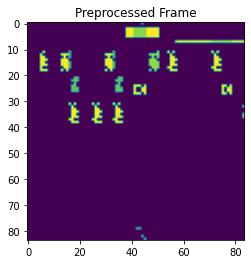

In [308]:
observation = env_c.reset()
observation = preprocess_state(observation, env_si)
plt.figure()
plt.imshow(observation)
plt.title('Preprocessed Frame')
plt.show()

## 7. Hyperparameters

In [198]:
def START_seed():
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [238]:
input_shape = (84, 84, 4)
action_size = env_si.action_space.n
n_stacked_frames = 4
START_seed()
gamma = 0.99           # discount factor
buffer_size = 20000   # replay buffer size
pretrain_length = 1000 # Number of experiences used to filled an initialiazed memory
batch_size = 64        # Update batch size
learning_rate = 0.001            # learning rate 
tau = 1e-3             # for soft update of target parameters
update_every = 1       # how often to update the network
update_after = 10000  # After which thershold replay to be started

# Exploration vs Explotaition tradeoff, epsilon decays over time
eps_start = 0.99        # starting value of epsilon
eps_end = 0.01          # Ending value of epsilon
eps_decay = 200         # Rate by which epsilon to be decayed

## 8. Neural networks

In [197]:
class DQN(nn.Module):

    def __init__(self, model_path='models/model.pt'):
        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.model_path = model_path

    def build_model(self, n_stacked_frames, n_actions, learning_rate):
        self.n_actions = n_actions
       # Architecture proposed in https://arxiv.org/abs/1312.5602

        self.model = Sequential(OrderedDict([
        ('conv_1', Conv2d(in_channels=n_stacked_frames, out_channels=16, kernel_size=(4, 4), stride=(4, 4))),
        ('activation_1', ReLU()),
        ('conv_2', Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), stride=(2, 2))),
        ('activation_2', ReLU()),
        ('flatten', Flatten()),
        ('linear_1', Linear(in_features=2592, out_features=256)),
        ('activation_4', ReLU()),
        ('linear_2', Linear(in_features=256, out_features=n_actions))]))

        self.model.to(self.device)

        # create model file if not present
        if not os.path.isfile(self.model_path):
            self.save_model()

    def print_model(self):
        summary(model=self.model, input_size=(1, 4, 84, 84))

    def predict(self, state):
        state_tensor = torch.tensor(state)
        return self.model(state_tensor.float().to(device))

    def save_model(self):

        print('Saving model')
        torch.save({
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self, training=False):
        
        state = torch.load(self.model_path)

        if training:
            print('Loading model to continue training')
            self.model.load_state_dict(state['state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])
            self.model.train()
        else:
            print('Loading model for inference')
            self.model.load_state_dict(state['state_dict'])
            self.model.eval()

In [213]:
observation = env_si.reset()

In [214]:
observation.shape

(210, 160, 3)

In [215]:
_  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

state, _ = stack_frames(_, observation, True, env_si)

In [216]:
model_test = DQN()

In [217]:
model_test.build_model(n_stacked_frames, action_size, learning_rate)

In [207]:
for param in model_test.model.parameters():
    param.requires_grad = False

True
True
True
True
True
True
True
True


In [212]:
state

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [224]:
model_test.predict(state)

tensor([[-0.0112,  0.0179, -0.0023,  0.0198,  0.0323, -0.0464]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [206]:
model_test.model

Sequential(
  (conv_1): Conv2d(4, 16, kernel_size=(4, 4), stride=(4, 4))
  (activation_1): ReLU()
  (conv_2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (activation_2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2592, out_features=256, bias=True)
  (activation_4): ReLU()
  (linear_2): Linear(in_features=256, out_features=6, bias=True)
)

## 9. The Replay Memory

In [171]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size), size = batch_size, replace = False)
        return [self.buffer[i] for i in index]

    def populating_memory(self, pretrain_length, env):
        for i in range(pretrain_length):
            # If it's the first step
            if i == 0:
                stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
                state = env.reset()
                state, stacked_frames = stack_frames(stacked_frames, state, True, env)
            # Get the next_state, the rewards, done by taking a random action
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)

            # Stack the frames
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False, env)
        
            # If the episode is finished (we're dead 3x)
            if done:
                # We finished the episode
                next_state = np.zeros(state.shape)
                
                # Add experience to memory
                self.add((state, action, reward, next_state, done))
                
                # Start a new episode
                state = env.reset()
                
                # Stack the frames
                state, stacked_frames = stack_frames(stacked_frames, state, True, env)
                
            else:
                # Add experience to memory
                self.add((state, action, reward, next_state, done))
                
                # Our new state is now the next_state
                state = next_state

In [313]:
memory_test = Memory(20000)

In [314]:
memory_test.populating_memory(64, env_si)

In [326]:
len(memory_test2.buffer[63])

5

In [325]:
memory_test2 = deepcopy(memory_test)

## 9. Watching it play before training

## 10. Training the agent

#### 10.1 Decay of epsilon

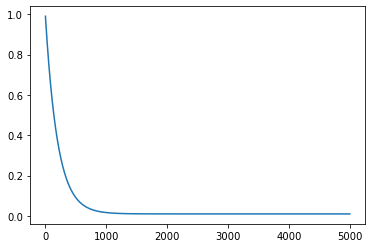

In [239]:
epsilon_by_episode = lambda frame_idx: eps_end + (eps_start - eps_end) * math.exp(-1. * frame_idx /eps_decay)
plt.plot([epsilon_by_episode(i) for i in range(5000)])

#### 10.2 Main training algorithm

![alt text](dql_algorithm.jpg "Title")

In [233]:
o = SGD(params=model.parameters(), lr=learning_rate)

In [287]:
def train(n_episodes=1000, game=env_si):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    start_epoch = 0
    scores = []
    scores_window = deque(maxlen=20)
    stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
    ########### Initialize replay memory D to capacity N (most of the sources indicate that N should be 1 million)
    memory = Memory(20000)
    memory.populating_memory(512, game)
    ########### Initialize action-value function Q with random weights Theta
    Q = DQN()
    Q.build_model(n_stacked_frames, action_size, learning_rate)
    ########### Initialize target action-value function Q_hat with weights Theta_ = Theta
    Q_hat = DQN()
    Q_hat.build_model(n_stacked_frames, action_size, learning_rate)
    Q_hat.load_state_dict(Q.state_dict())
    
    optimizer = SGD(lr=learning_rate, params=Q.parameters())
    #optimizer = Adam(lr=learning_rate, params=Q.parameters())
    loss = MSELoss()
    
    for i_episode in range(start_epoch + 1, n_episodes+1):
        initial_state = game.reset()
        state, frames_deque = stack_frames(stacked_frames, initial_state, True, game)
        score = 0
        eps = epsilon_by_episode(i_episode)
        C = 0
        counter = 0
        rand_int_frames = random.randint(3,5)
        K = random.randint(5,10)
        
        for _ in range(K):
            rand_init_state_action = random.randint(2,3)
            state, ret_2, ret_3, ret_4 = game.step(rand_init_state_action)
            state, frames_deque = stack_frames(stacked_frames, state, False, game)
            
        while True:
            # Random frame skipping
            if counter % rand_int_frames == 0:
                if random.random() <= eps:
                    selected_a_t = game.action_space.sample()
                else:
                    q = Q.predict(state)
                    selected_a_t = torch.argmax(q)
                rand_int_frames = random.randint(3,5)
            counter += 1

            action = selected_a_t ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy

            next_state, reward, done, _ = game.step(action)
            
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False, game) ############ Here we need the preprocessing function

            ############### Here we store the transition (phi_(t), a_(t), r_(t), phi_(t+1)) in D
            memory.add((state, action, reward, next_state, done))

            ################# Training phase ######################
            ####### 1.- Sample random minibatch with uniform distribution of transitions (phi_(j), a_(j), r_(j), phi_(j+1)) from D
            minibatch = memory.sample(16)
            
            ####### 2.- Calculate the target value "y"
            
            ####### Our approach
            target_q_values = torch.tensor([], requires_grad=True).to(device)
            predictions = torch.tensor([], requires_grad=True).to(device)

            for s_t, a_t, r_t, s_t1, done in minibatch:
                q_s_t1 = Q_hat.predict(s_t1)  # Predicted Q values for the next state
                target = Q.predict(s_t)  # Predicted Q values

                new_target = torch.tensor([r_t + (1 - done) * gamma * torch.max(q_s_t1)]).to(device)
                predicted_q_value = torch.tensor(target[0, a_t]).to(device)
                predicted_q_value = predicted_q_value.unsqueeze(0)
                
                target_q_values = torch.cat((target_q_values, new_target), dim=0)
                predictions = torch.cat((predictions, predicted_q_value), dim=0)
            
            loss_computation = loss(predictions, target_q_values)
            optimizer.zero_grad()
            loss_computation.backward()
            optimizer.step()
            loss_test = loss_computation.item()
            
            ####### Another approach
            #target_q_values = torch.tensor([]).to(device)
            #s_t1_q_values = torch.tensor([]).to(device)

            #for s_t, a_t, r_t, s_t1, done in minibatch:
            #    q_s_t1 = Q_hat.predict(s_t1)  # Predicted Q values for the next state
            #    target = Q.predict(s_t)  # Predicted Q values
            #    target[:, a_t] = r_t + (1 - done) * gamma * torch.max(q_s_t1)
                
            #    optimizer.zero_grad()
            #    prediction = Q.predict(s_t)
            #    loss_computation = loss(prediction, target)
            #    loss_computation.backward()
            #    optimizer.step()
            #    current_loss += loss_computation.item()
            
            ####### Nico's approach
            #target_q_values = torch.tensor([]).to(device)
            #s_t1_q_values = torch.tensor([]).to(device)
            
            
            #for s_t, a_t, r_t, s_t1, done in minibatch:

            #    target = Q.predict(s_t)  # Predicted Q values
            #    q_s_t1 = Q_hat.predict(s_t1)  # Predicted Q values for the next state

            #    target[:, a_t] = r_t + (1 - done) * gamma * torch.max(q_s_t1)

                
            #    target_q_values = torch.cat((target_q_values, target), dim=0)
            #    s_t1_q_values = torch.cat((s_t1_q_values, q_s_t1), dim=0)

            #MSE = loss(s_t1_q_values, target_q_values)
            #optimizer.zero_grad()
            #MSE.backward()
            #optimizer.step()
            #loss_test = MSE.item()

            state = next_state
            score += reward
            
            ############### Every C steps reset Q_hat = Q, we train only on Q
            if C % 15 == 0:
                Q_hat.load_state_dict(Q.state_dict())
                
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # Plotting
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    return Q, scores

Episode 50	Average Score: 5.50


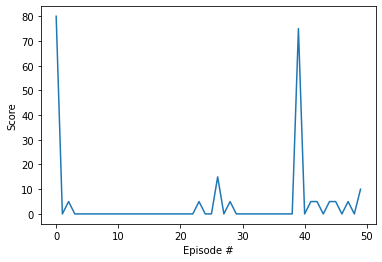

Episode 100	Average Score: 5.00


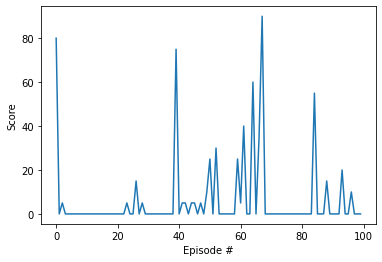

Episode 150	Average Score: 9.750


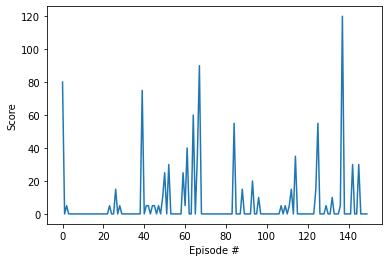

Episode 200	Average Score: 4.50


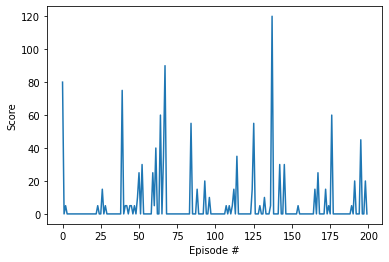

Episode 250	Average Score: 9.75


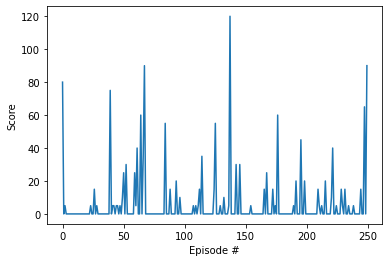

Episode 300	Average Score: 1.00


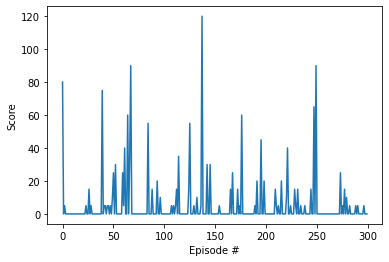

Episode 350	Average Score: 14.75


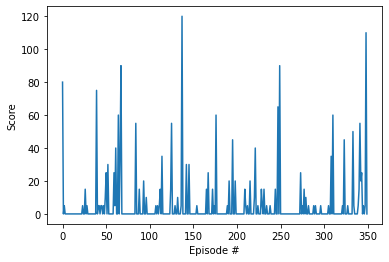

Episode 400	Average Score: 8.500


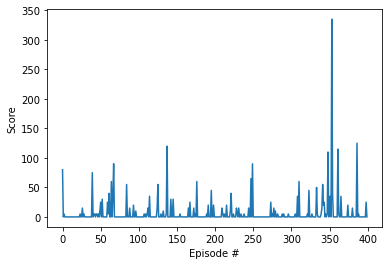

Episode 450	Average Score: 9.005


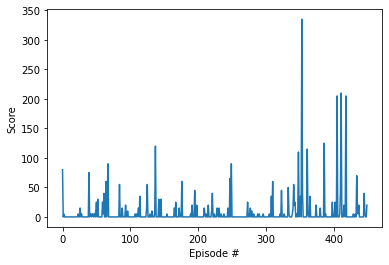

Episode 500	Average Score: 3.250


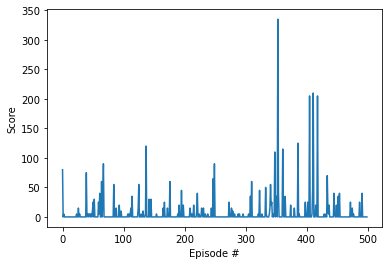

Episode 550	Average Score: 16.25


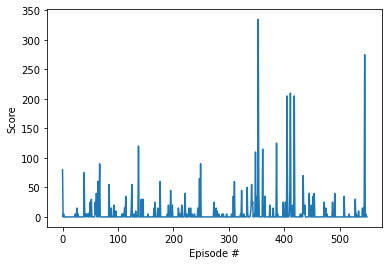

Episode 600	Average Score: 2.505


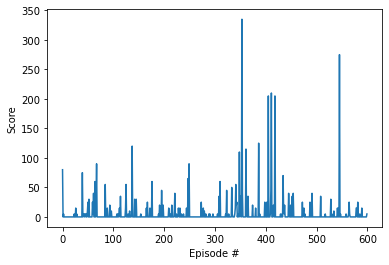

Episode 650	Average Score: 6.005


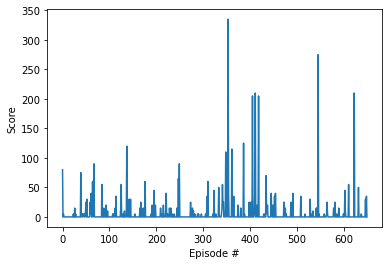

Episode 700	Average Score: 10.50


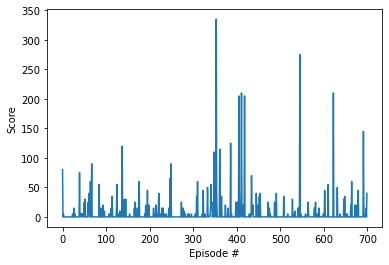

Episode 750	Average Score: 0.750


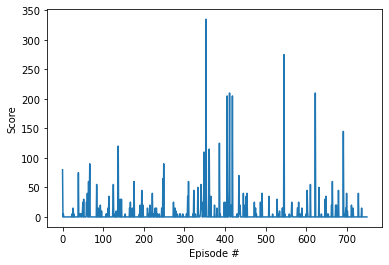

Episode 800	Average Score: 28.75


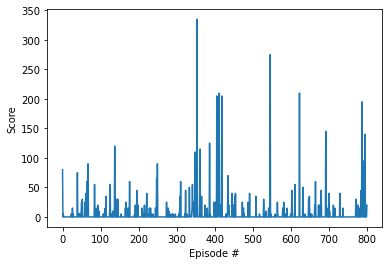

Episode 850	Average Score: 0.005


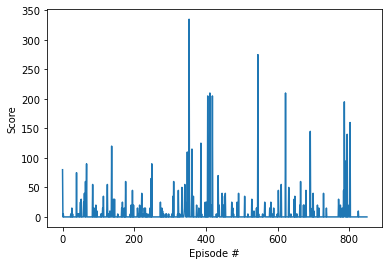

Episode 900	Average Score: 5.00


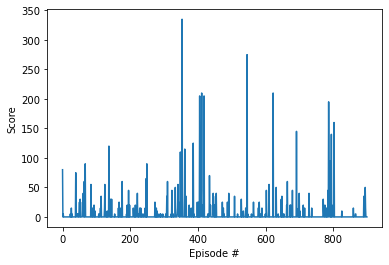

Episode 950	Average Score: 2.50


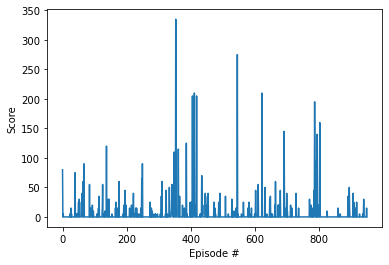

Episode 1000	Average Score: 7.00


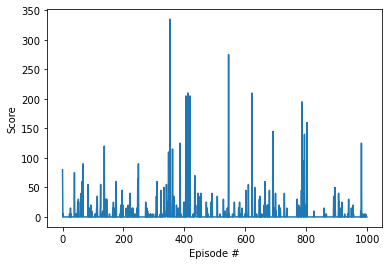

Episode 1050	Average Score: 6.25


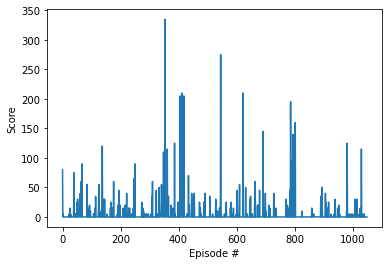

Episode 1100	Average Score: 6.50


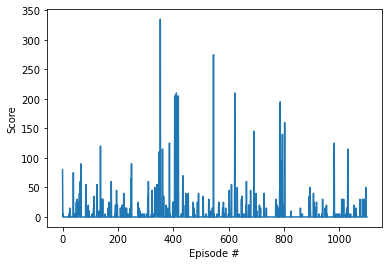

Episode 1150	Average Score: 3.00


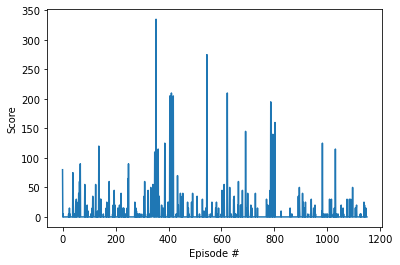

Episode 1200	Average Score: 2.25


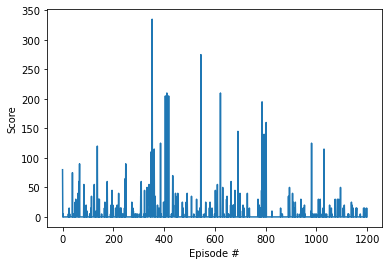

Episode 1250	Average Score: 6.50


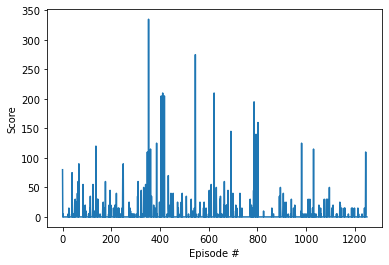

Episode 1300	Average Score: 2.00


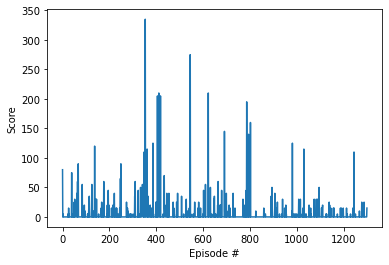

Episode 1350	Average Score: 2.50


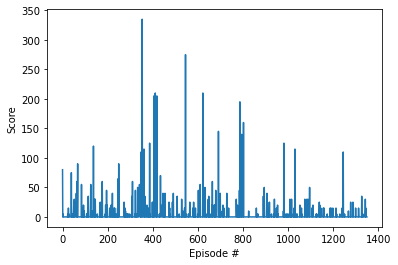

Episode 1400	Average Score: 3.75


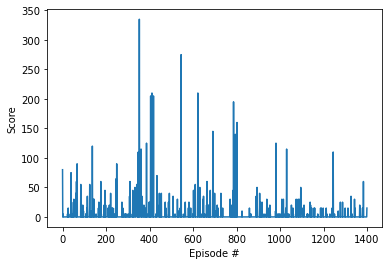

Episode 1450	Average Score: 5.25


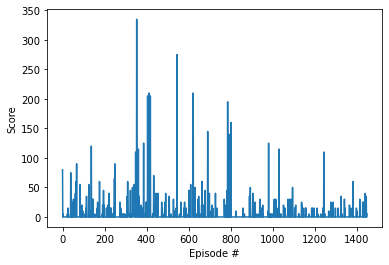

Episode 1500	Average Score: 2.000


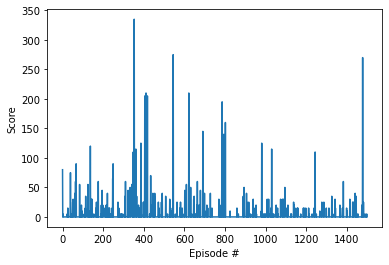

Episode 1550	Average Score: 1.25


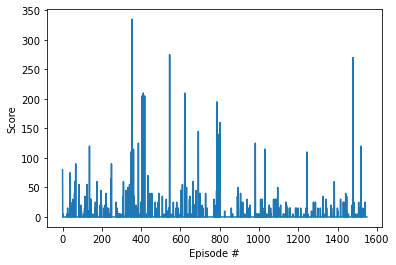

Episode 1600	Average Score: 4.50


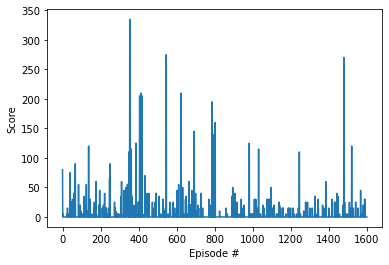

Episode 1650	Average Score: 3.750


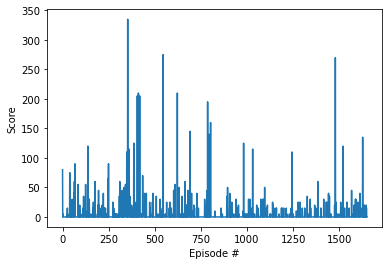

Episode 1700	Average Score: 6.75


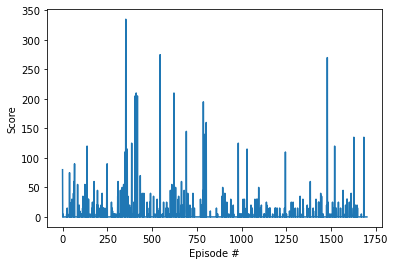

Episode 1750	Average Score: 1.25


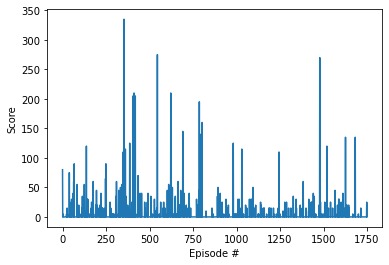

Episode 1800	Average Score: 0.75


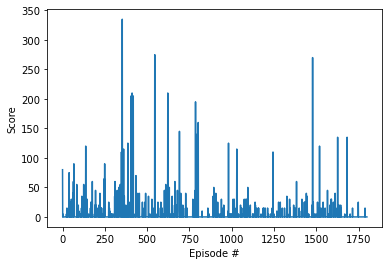

Episode 1850	Average Score: 0.00


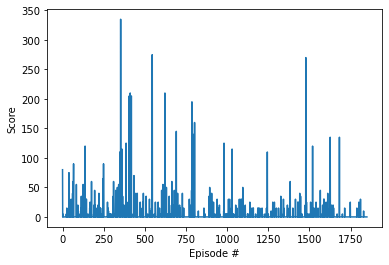

Episode 1900	Average Score: 2.25


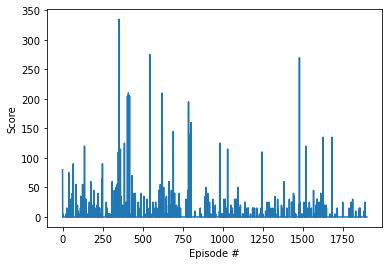

Episode 1950	Average Score: 7.50


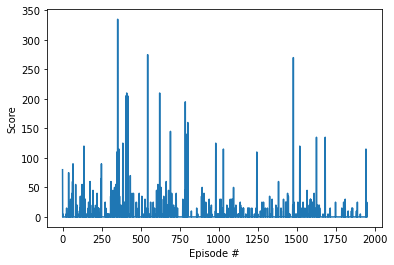

Episode 2000	Average Score: 6.50


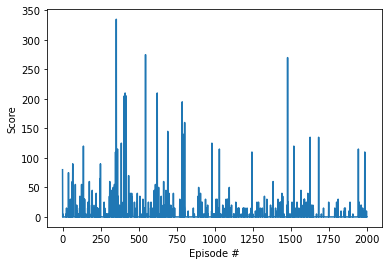

Episode 2050	Average Score: 1.25


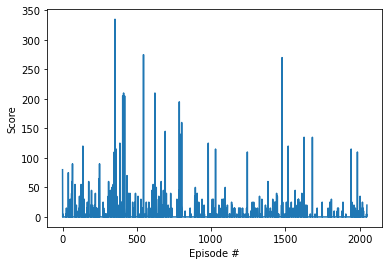

Episode 2100	Average Score: 5.50


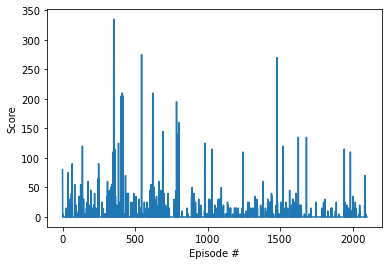

Episode 2150	Average Score: 13.25


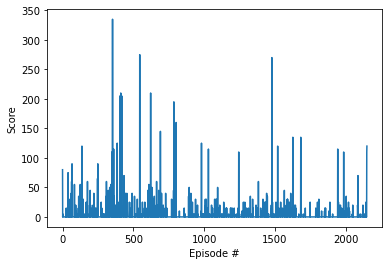

Episode 2200	Average Score: 3.500


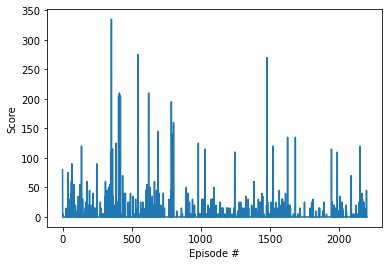

Episode 2250	Average Score: 0.000


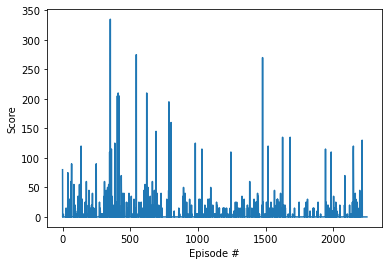

Episode 2300	Average Score: 0.00


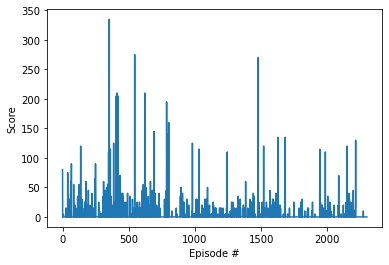

Episode 2350	Average Score: 0.00


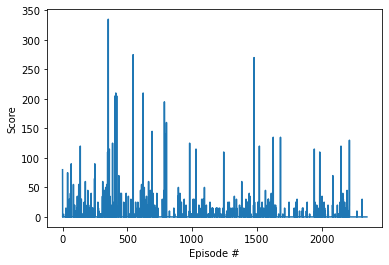

Episode 2400	Average Score: 0.00


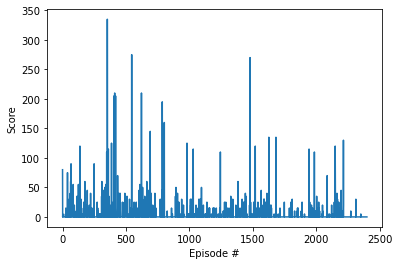

Episode 2450	Average Score: 0.00


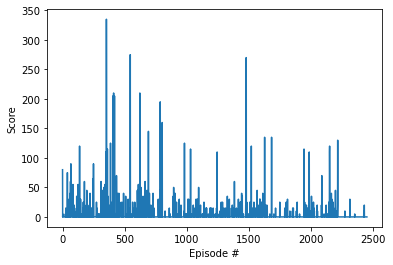

Episode 2500	Average Score: 0.25


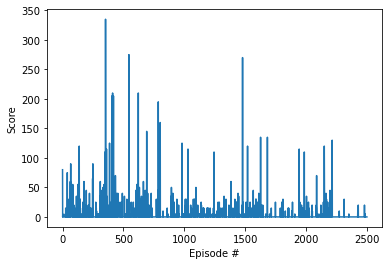

Episode 2550	Average Score: 0.00


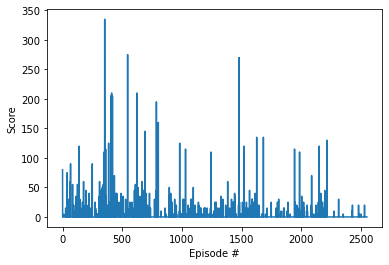

Episode 2600	Average Score: 41.00


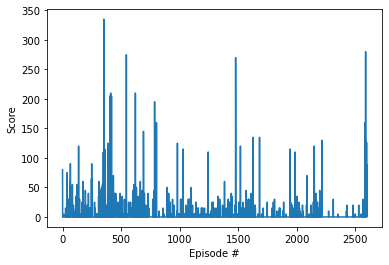

Episode 2650	Average Score: 0.005


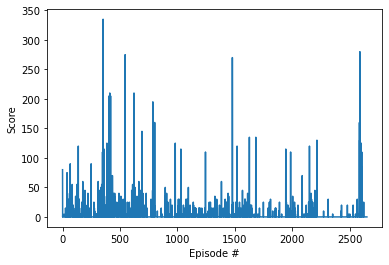

Episode 2700	Average Score: 2.00


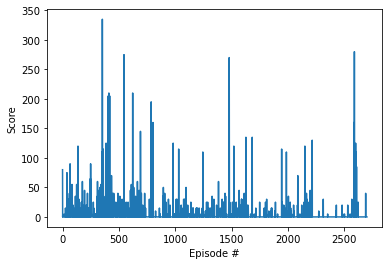

Episode 2750	Average Score: 0.00


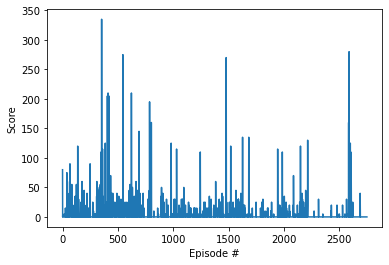

Episode 2800	Average Score: 0.00


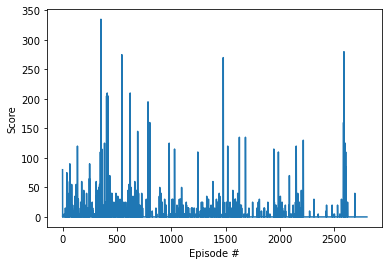

Episode 2850	Average Score: 1.00


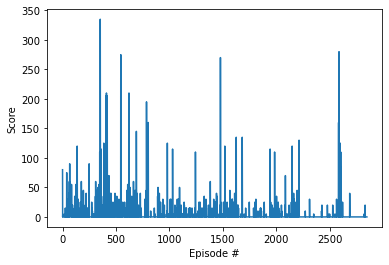

Episode 2900	Average Score: 2.00


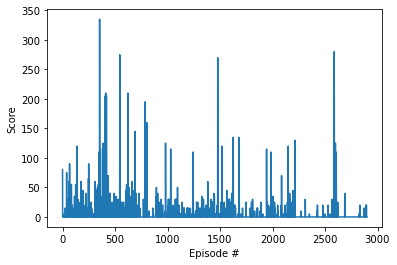

Episode 2950	Average Score: 0.50


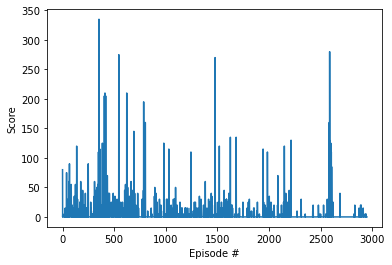

Episode 3000	Average Score: 18.00


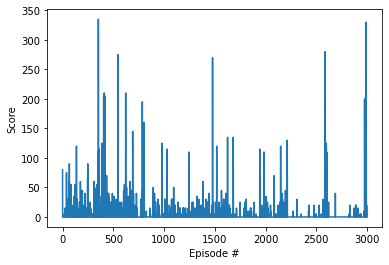

Episode 3050	Average Score: 2.005


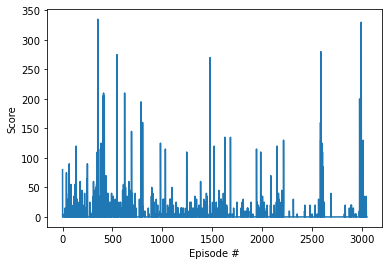

Episode 3100	Average Score: 3.250


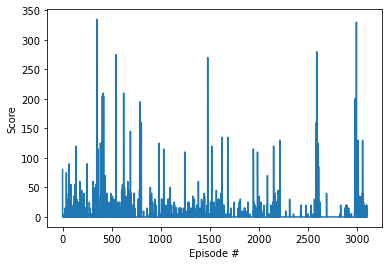

Episode 3150	Average Score: 4.250


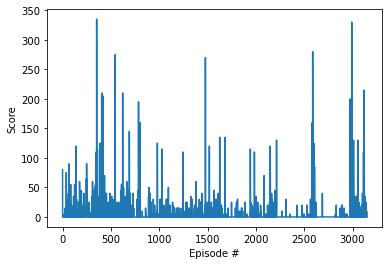

Episode 3200	Average Score: 0.75


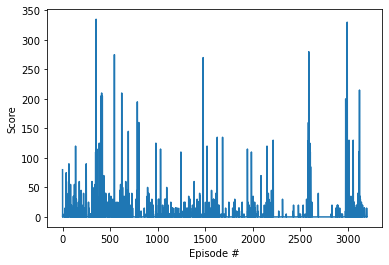

Episode 3250	Average Score: 1.25


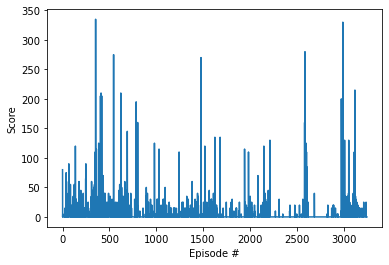

Episode 3300	Average Score: 8.00


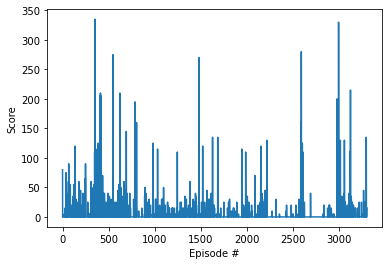

Episode 3350	Average Score: 1.25


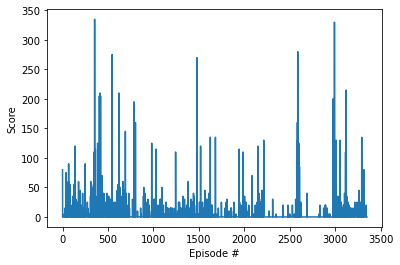

Episode 3400	Average Score: 0.00


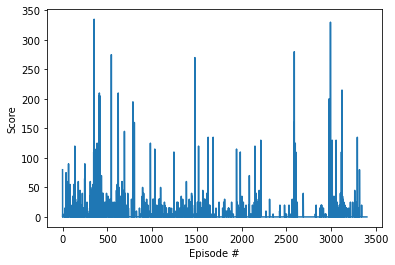

Episode 3450	Average Score: 0.50


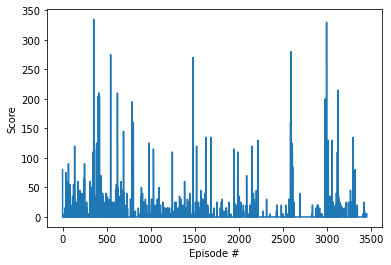

Episode 3500	Average Score: 2.00


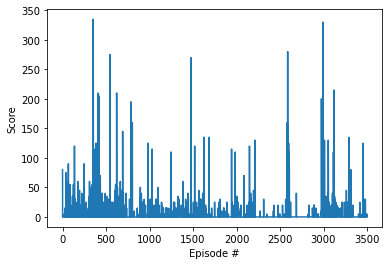

Episode 3550	Average Score: 3.25


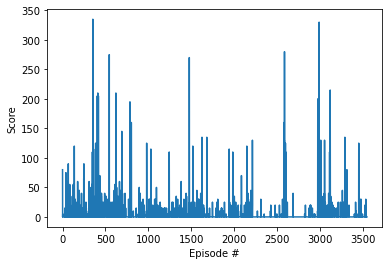

Episode 3600	Average Score: 5.005


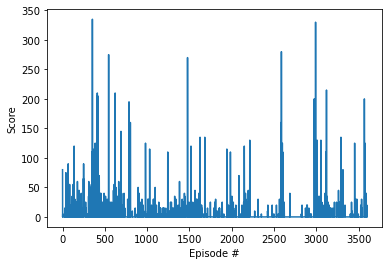

Episode 3650	Average Score: 0.005


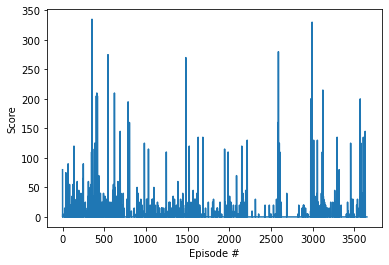

Episode 3700	Average Score: 0.00


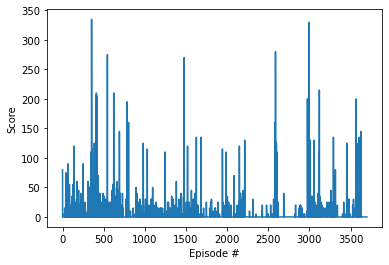

Episode 3750	Average Score: 0.25


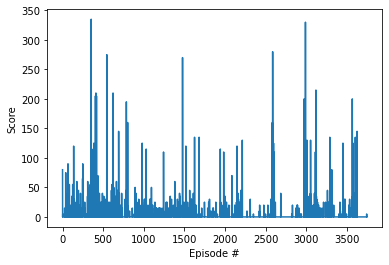

Episode 3800	Average Score: 0.75


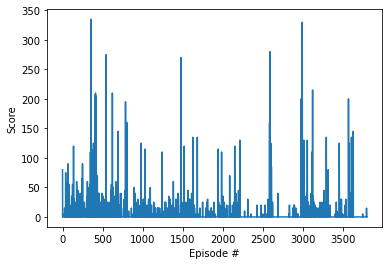

Episode 3850	Average Score: 1.50


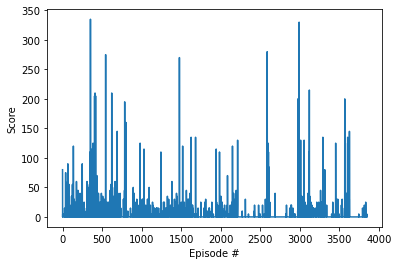

Episode 3900	Average Score: 1.25


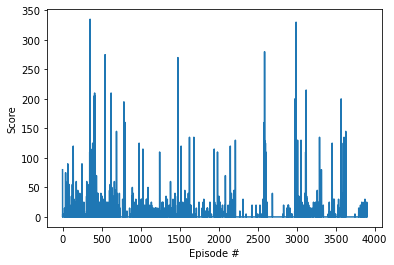

Episode 3950	Average Score: 0.00


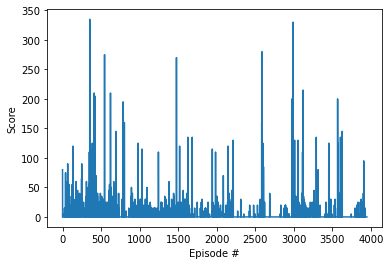

Episode 4000	Average Score: 0.75


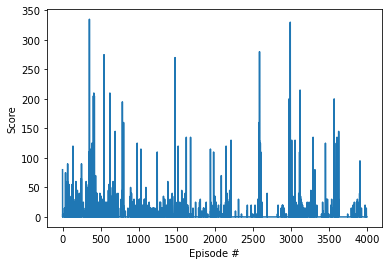

Episode 4050	Average Score: 0.00


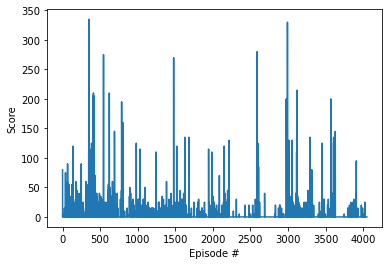

Episode 4100	Average Score: 2.00


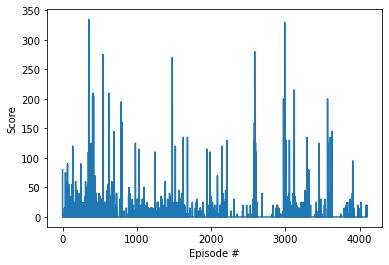

Episode 4150	Average Score: 0.25


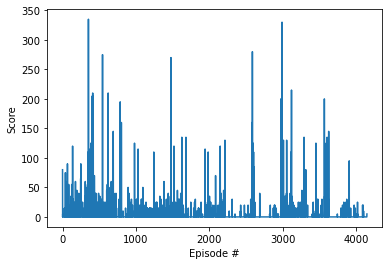

Episode 4200	Average Score: 0.25


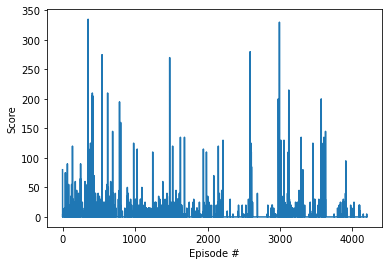

Episode 4250	Average Score: 0.00


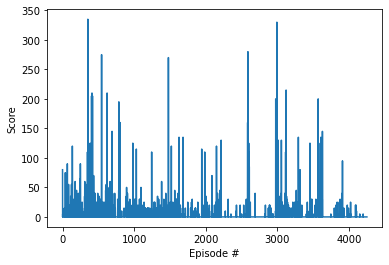

Episode 4300	Average Score: 4.255


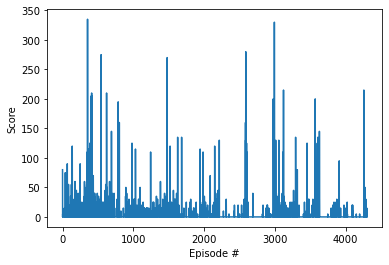

Episode 4350	Average Score: 8.000


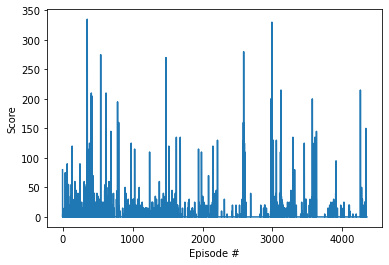

Episode 4400	Average Score: 1.75


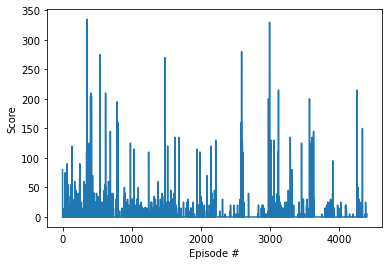

Episode 4450	Average Score: 15.50


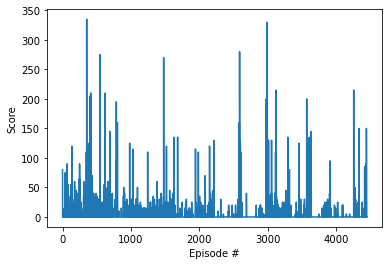

Episode 4500	Average Score: 1.005


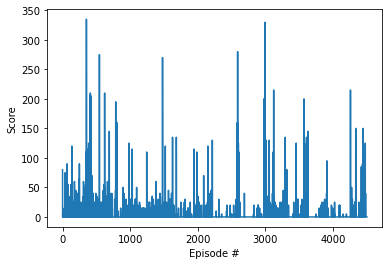

Episode 4550	Average Score: 0.00


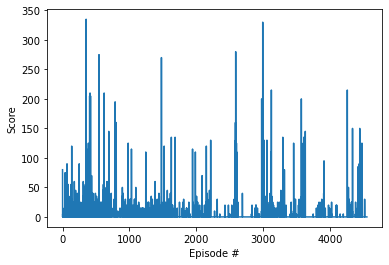

Episode 4600	Average Score: 0.25


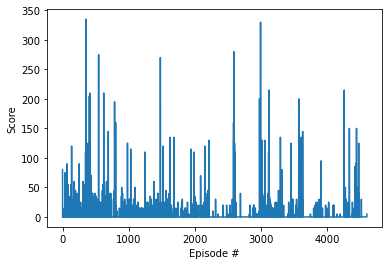

Episode 4650	Average Score: 0.00


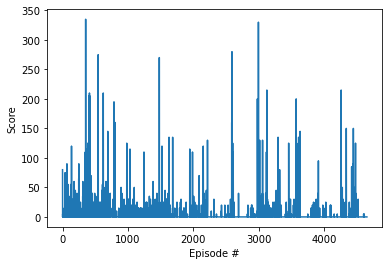

Episode 4700	Average Score: 2.50


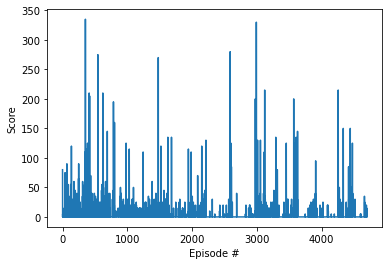

Episode 4750	Average Score: 0.00


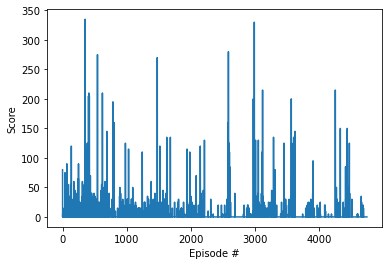

Episode 4800	Average Score: 0.25


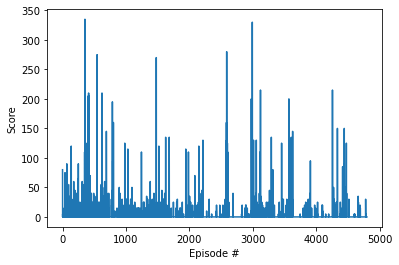

Episode 4850	Average Score: 1.505


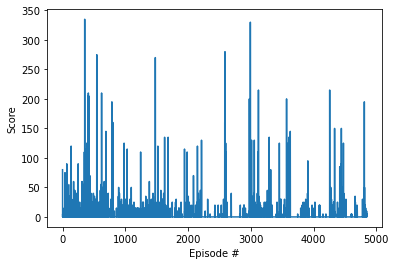

Episode 4900	Average Score: 1.00


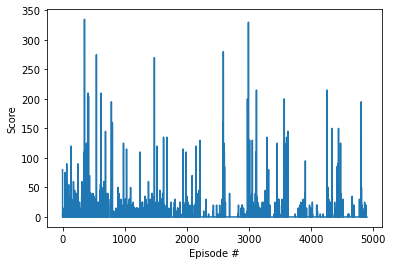

Episode 4950	Average Score: 3.50


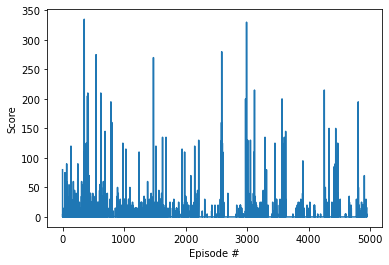

Episode 5000	Average Score: 6.50


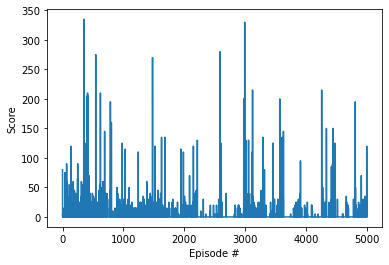

In [288]:
agent, scores = train(5000, env_si)

## 11. Evaluate the agent

In [335]:
score = 0
observation = env_si.reset()
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
state, stacked_frames_deque = stack_frames(stacked_frames, observation, True, env_si) ############ Here we need the preprocessing function
while True:
    env_si.render()
    q = agent2.predict(state)
    a_t = torch.argmax(q) ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy
    next_state, reward, done, _ = env_si.step(a_t)
    score += reward
    state, stacked_frames_deque = stack_frames(stacked_frames_deque, next_state, False, env_si) ########## Here we need the preprocessing function
    if done:
        print("You Final score is:", score)
        break
    time.sleep(0.01)
env_si.close()

You Final score is: 285.0


In [303]:
agent.state_dict()

OrderedDict([('model.conv_1.weight',
              tensor([[[[ 6.6184e-02,  1.1115e-01, -4.6139e-02, -5.3296e-02],
                        [-1.2031e-01,  1.0557e-02,  1.0191e-01,  6.4782e-02],
                        [-4.8306e-02,  6.3404e-02, -5.5087e-03, -2.0211e-02],
                        [-2.6661e-02, -5.0013e-02,  3.5017e-02,  1.1311e-01]],
              
                       [[ 2.9735e-02, -1.1164e-01, -6.3183e-02,  8.3620e-03],
                        [ 1.1769e-01,  7.7098e-03, -8.0066e-02,  2.8098e-02],
                        [-2.8466e-02,  5.6854e-02, -3.4190e-02,  3.2232e-02],
                        [-1.6763e-03,  8.1128e-02, -7.8518e-02,  6.7151e-02]],
              
                       [[-7.0277e-02,  1.8048e-02, -1.2118e-01, -1.0844e-01],
                        [ 1.5315e-02,  4.8458e-02,  2.2256e-02,  9.2680e-02],
                        [ 4.1304e-02,  1.0141e-01,  1.1738e-01,  1.9867e-02],
                        [ 6.4687e-02,  8.3578e-02,  8.4335e-02, -4.9953e-

In [311]:
print('Saving model')
torch.save({'state_dict': agent.model.state_dict()}, '/home/mario.cantero/AI701Project_MNM_RL/agent.pt')

Saving model


In [327]:
agent2 = DQN()

In [332]:
agent2.build_model(n_stacked_frames, action_size, learning_rate)
agent2.model.load_state_dict(torch.load('/home/mario.cantero/AI701Project_MNM_RL/agent.pt')['state_dict'])

<All keys matched successfully>